<a href="https://colab.research.google.com/github/keamanansiber/Maryam/blob/master/notebooks/Prototipe_2_TopicModeling_NMF_LDA_21062022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# core/util/iris/topicmodeling.py

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import json
import pandas as pd


class topicmodeling:

	def __init__(self, input_json):

		self.n_samples = 2000
		self.n_features = 1000
		self.n_components = 5
		self.n_top_words = 20
		self.batch_size = 128
		self.init = "nndsvda"

		# dataset
		print("reading json file")
		with open(input_json) as json_file:
			self.jsonfile = json.load(json_file)
   
		print("\n\n self.jsonfile = ")
		print(self.jsonfile)

		tmp = pd.DataFrame(self.jsonfile['results'])
		tmp['td'] = tmp['t'] + ' ' + tmp['d']
		self.data_samples = tmp['td'].to_numpy()
  
		print("\n\n self.data_samples = ")
		print(self.data_samples)


		# Use tf-idf features for NMF.
		print("\n\n Extracting tf-idf features for NMF...")
		self.tfidf_vectorizer = TfidfVectorizer(
			max_df=0.95, min_df=2, max_features=self.n_features, stop_words="english"
		)
		self.tfidf = self.tfidf_vectorizer.fit_transform(self.data_samples)
		print("\n\n self.tfidf = ")
		print(self.tfidf)


		# Use tf (raw term count) features for LDA.
		print("Extracting tf features for LDA...")
		self.tf_vectorizer = CountVectorizer(
			max_df=0.95, min_df=2, max_features=self.n_features, stop_words="english"
		)
		self.tf = self.tf_vectorizer.fit_transform(self.data_samples)
		print("\n\n self.tf = ")
		print(self.tf)


	def plot_top_words(self, model, feature_names, n_top_words, title):
		fig, axes = plt.subplots(self.n_components//5, 5, figsize=(30, 15), sharex=True)
		axes = axes.flatten()
		for topic_idx, topic in enumerate(model.components_):
			top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
			top_features = [feature_names[i] for i in top_features_ind]
			weights = topic[top_features_ind]

			ax = axes[topic_idx]
			ax.barh(top_features, weights, height=0.7)
			ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
			ax.invert_yaxis()
			ax.tick_params(axis="both", which="major", labelsize=20)
			for i in "top right left".split():
				ax.spines[i].set_visible(False)
			fig.suptitle(title, fontsize=40)

		plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
		plt.show()


	# NMF model (Frobenius norm)
	def perform_nmf1(self):

		# Fit the NMF model
		print(
			"Fitting the NMF model (Frobenius norm) with tf-idf features, "
			"n_samples=%d and n_features=%d..." % (self.n_samples, self.n_features)
		)
		nmf = NMF(
			n_components=self.n_components,
			random_state=1,
			init=self.init,
			beta_loss="frobenius",
			alpha_W=0.00005,
			alpha_H=0.00005,
			l1_ratio=1,
		).fit(self.tfidf)

		tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
		self.plot_top_words(
			nmf, tfidf_feature_names, self.n_top_words, "Topics in NMF model (Frobenius norm)"
		)


	# NMF model (generalized Kullback-Leibler divergence)
	def perform_nmf2(self):

		# Fit the NMF model
		print(
			"\n" * 2,
			"Fitting the NMF model (generalized Kullback-Leibler "
			"divergence) with tf-idf features, n_samples=%d and n_features=%d..."
			% (self.n_samples, self.n_features),
		)
		nmf = NMF(
			n_components=self.n_components,
			random_state=1,
			init=self.init,
			beta_loss="kullback-leibler",
			solver="mu",
			max_iter=1000,
			alpha_W=0.00005,
			alpha_H=0.00005,
			l1_ratio=0.5,
		).fit(self.tfidf)

		tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
		self.plot_top_words(
			nmf,
			tfidf_feature_names,
			self.n_top_words,
			"Topics in NMF model (generalized Kullback-Leibler divergence)",
		)


	# LDA models
	def perform_lda(self):

		print(
			"\n" * 2,
			"Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
			% (self.n_samples, self.n_features),
		)
		lda = LatentDirichletAllocation(
			n_components=self.n_components,
			max_iter=5,
			learning_method="online",
			learning_offset=50.0,
			random_state=0,
		)
		lda.fit(self.tf)

		tf_feature_names = self.tf_vectorizer.get_feature_names_out()
		self.plot_top_words(lda, tf_feature_names, self.n_top_words, "Topics in LDA model")



In [2]:
# Use dataset from Mr. Khausik's work https://github.com/k4u5h1k/Doclustering/blob/main/mixed.json
jsonfile = "mixed.json"

In [3]:
tm = topicmodeling(jsonfile)

reading json file


 self.jsonfile = 
{'results': [{'t': 'Movie Coverage - YouTube', 'a': 'https://www.youtube.com/channel/UCwYzZs_hwA6NdaQp6Hjhe5w', 'c': 'www.youtube.com › channel', 'd': 'The best of films and movie trailers. Pick your Favorite Genre in our playlists.Do you want your trailer featured on this channel ? Please feel free to conta...'}, {'t': 'Marvel Studios Celebrates The Movies - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3DQdpxoFcdORI', 'c': 'www.youtube.com › watch', 'd': 'Duration:     3:11    Posted:     3 days ago               \xa0\xa0VIDEO'}, {'t': 'FRESH Movie Trailers - YouTube', 'a': 'https://www.youtube.com/c/FreshMovieTrailers', 'c': 'www.youtube.com › FreshMovieTrailers', 'd': "All NEW MOVIE TRAILERS are Here! Don't miss the latest movie trailers and weekly recaps.You want your trailer featured on the channel ? Fell free to reach\xa0..."}, {'t': 'Movie: The Movie - YouTube', 'a': 'https://www.youtube.com/watch%3Fv%3Dw3NwB9PLxss', 'c': 'www.youtube.c

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


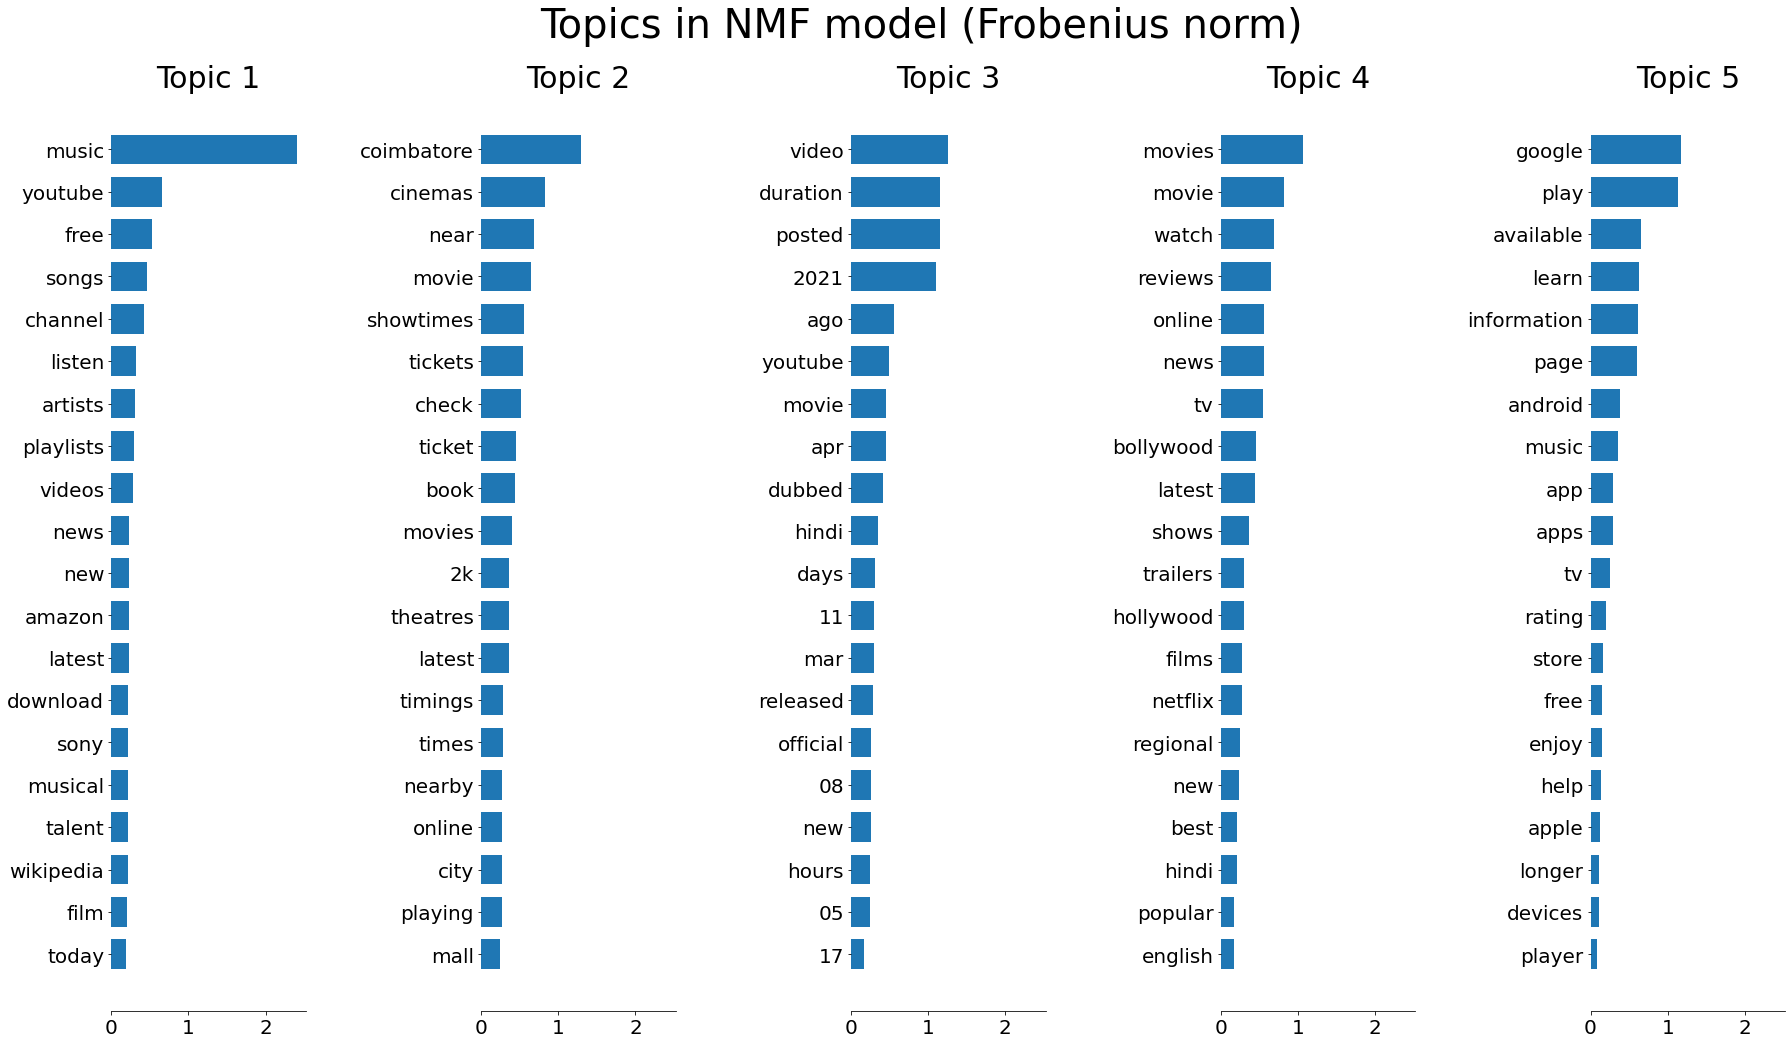

In [4]:
tm.perform_nmf1()



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


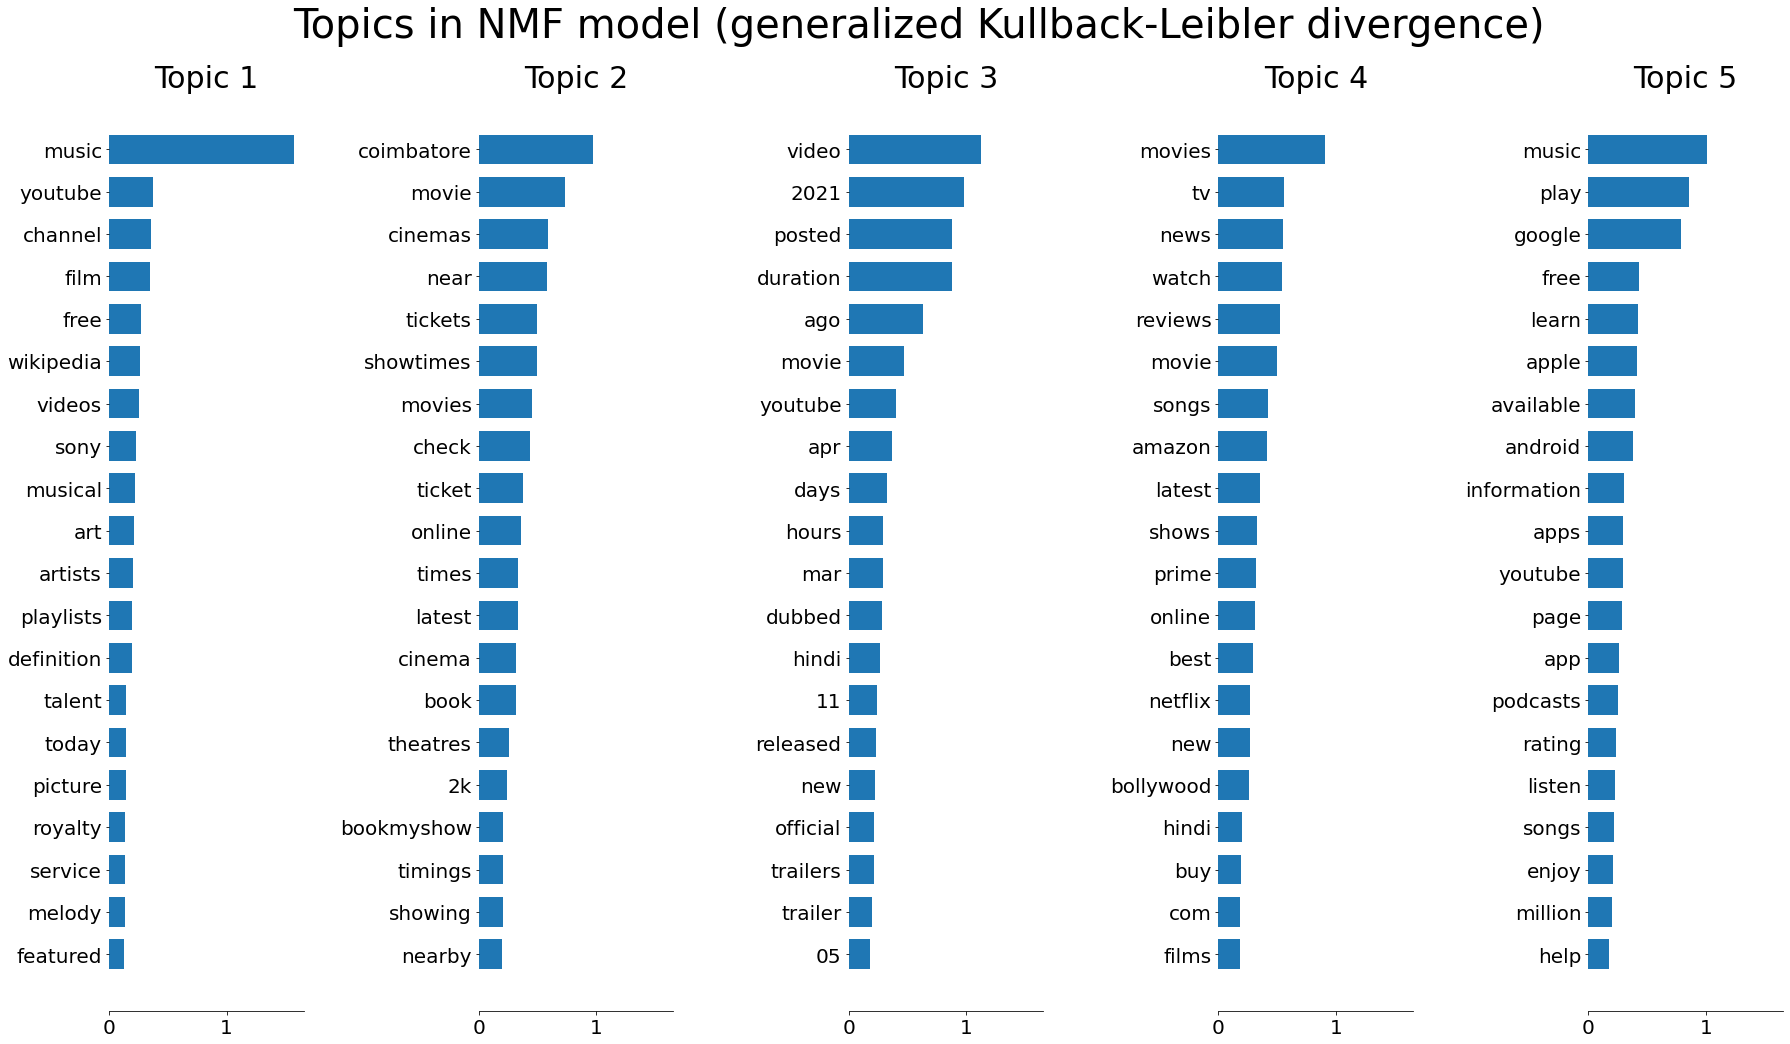

In [5]:
tm.perform_nmf2()



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


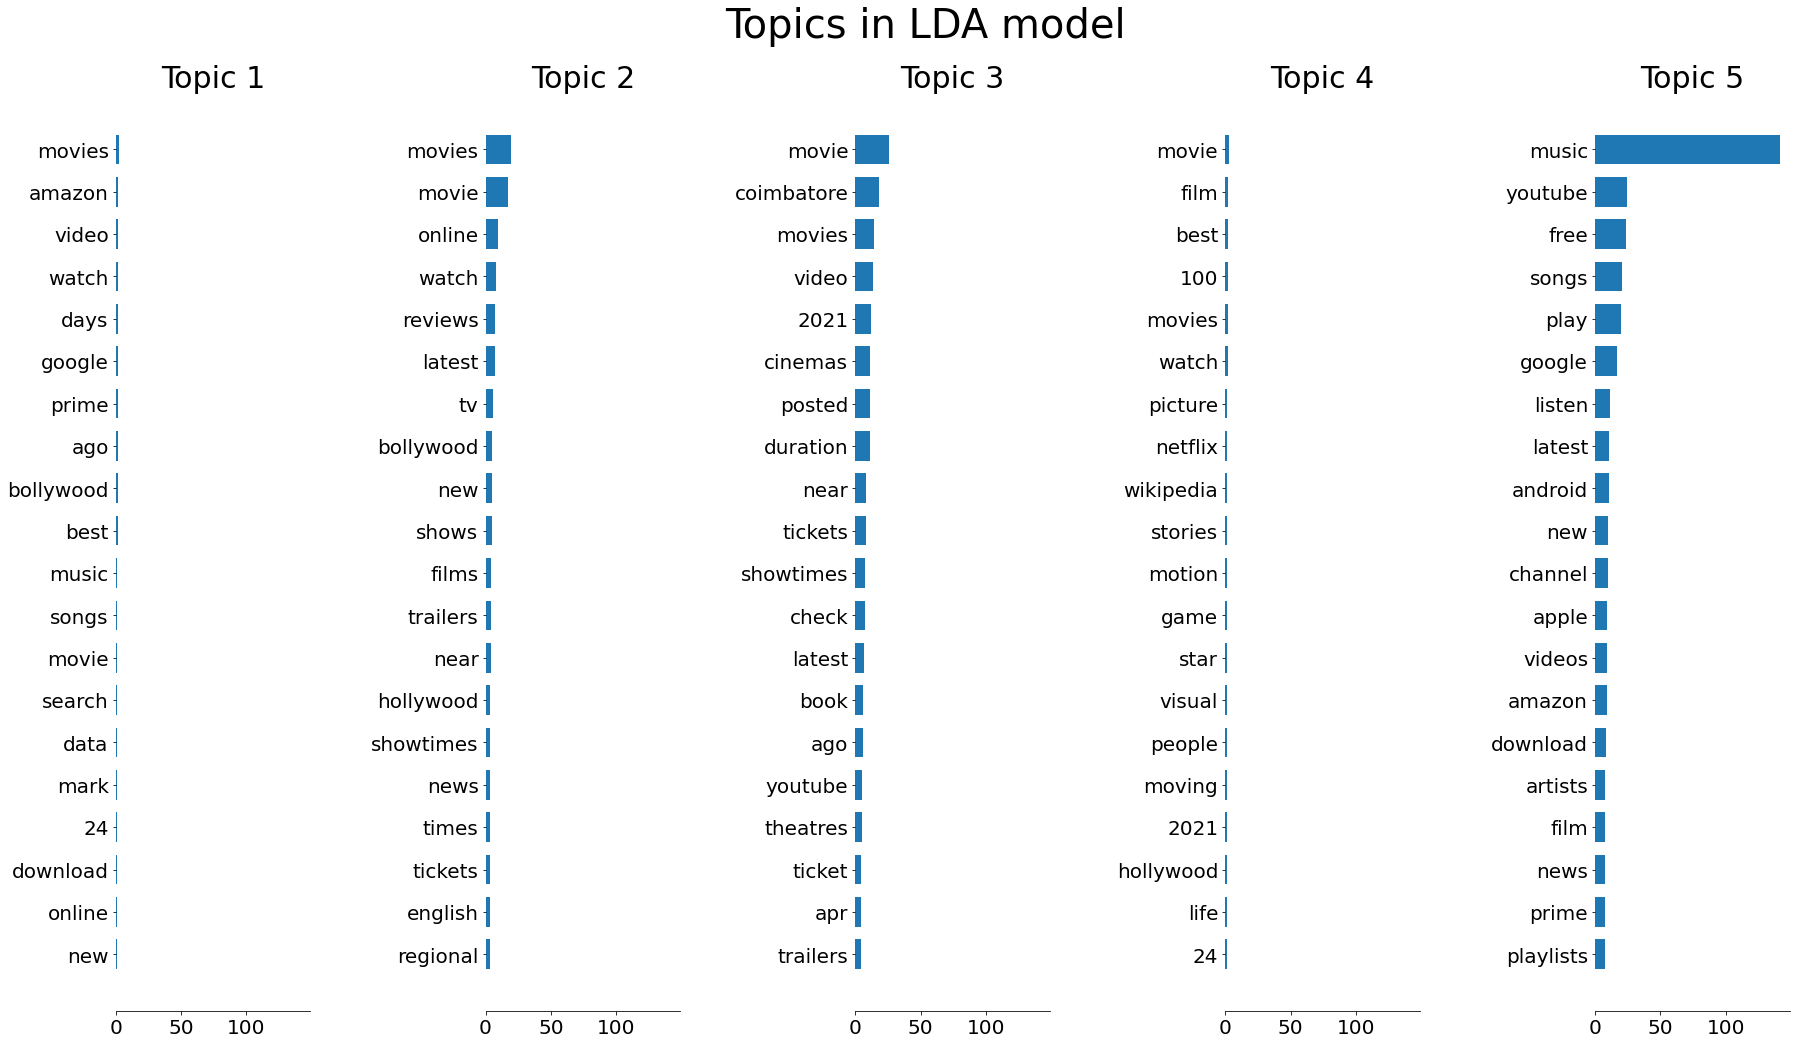

In [6]:
tm.perform_lda()

Following tutorial from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html